# StackedAutoEncoder predictor

## Author: Danilo Filippo Reiszel Pereira
Univesidade Federal do Rio de Janeiro

This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of PETR4 stocks, as input 10 delays of it's residual series and some auxiliary, using the StackedAutoEncoder approach for pre-training

In [1]:
from __future__ import print_function
import sys, os
sys.path.append('../../../../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

Using TensorFlow backend.


## Global Params
Setting global params and useful variables, such as directories and image styling

In [2]:
asset = 'VALE5'
pathAsset = '../../../../../data/stocks/{}/diario/{}.CSV'.format(asset, asset)
pathIBOV = '../../../../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../../../../data/forex/USDBRL/diario/USDBRL.CSV'

saveVarDir = './Variables'
os.makedirs(saveVarDir) if not os.path.exists(saveVarDir) else print('saveVarDir already exists')

saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('saveFigDir already exists')

saveModelDir = './Models'
os.makedirs(saveModelDir) if not os.path.exists(saveModelDir) else print('saveModelDir already exists')

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

saveVarDir already exists
saveFigDir already exists
saveModelDir already exists


## Data Acquisition and Preprocessing

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

<strong>Parameters for trend extraction:</strong>
<ul>
    <li>Column: Close</li>
    <li>Decompose model: Additive</li>
    <li>Fitting Order: 1 (by default)</li>
    <li>Window Size: 6</li>
    <li>Fitting Weigths Model: Autocorrelation</li>
    <li>Fitting Weigths Model Window Size: 18</li>
</ul>

In [ ]:
init_time = time.time()

ASSET = acquireData(filePath = pathAsset, dropNan = True)
IBOV = acquireData(filePath = pathIBOV, dropNan = True)
USDBRL= acquireData(filePath = pathUSDBRL, dropNan = True)

df = pd.concat([ASSET, IBOV, USDBRL], axis = 1).dropna()

end_time = time.time()
print('Time to acquire and process data: '+str(end_time-init_time)+' seconds')

In [3]:
pathAsset = './Variables/{}_SAE_predicted.CSV'.format(asset)
df = pd.read_csv(pathAsset, parse_dates=['Date'], index_col='Date').sort_index()
df.columns

Index([u'VALE5_Close', u'VALE5_Open', u'VALE5_High', u'VALE5_Low',
       u'VALE5_Volume', u'VALE5_Quantity', u'VALE5_Holiday',
       u'VALE5_Close_rollMean20', u'VALE5_Close_rollStd20',
       u'VALE5_Close_EMA17', u'VALE5_Close_EMA17_logdiff',
       u'VALE5_Close_EMA72', u'VALE5_Close_EMA72_logdiff',
       u'VALE5_Close_EMA200', u'VALE5_Close_EMA200_logdiff',
       u'VALE5_Volume_EMA21', u'VALE5_Volume_EMA21_logdiff',
       u'VALE5_MACD_12_26_9', u'VALE5_MACDsignal_12_26_9',
       u'VALE5_MACDdiff_12_26_9', u'VALE5_BollingerMA_20',
       u'VALE5_BollingerUpper_20', u'VALE5_BollingerLower_20',
       u'VALE5_Bollinger%b_20', u'VALE5_OBV', u'VALE5_Close_returns',
       u'VALE5_Close/Open_returns', u'VALE5_High/Close_returns',
       u'VALE5_Low/Close_returns', u'VALE5_Close_trend', u'VALE5_Close_resid',
       u'IBOV_Close', u'IBOV_Open', u'IBOV_High', u'IBOV_Low', u'IBOV_Volume',
       u'IBOV_Quantity', u'IBOV_Holiday', u'IBOV_Close_rollMean20',
       u'IBOV_Close_rollStd20'

## Dataset concatenation and selection of wich features to feed to the model

In [4]:
columnsToUse = ['{}_Close_resid',
                '{}_Close_rollStd20', 
                '{}_Close_returns', '{}_Close/Open_returns', '{}_High/Close_returns', '{}_Low/Close_returns', 
                '{}_Close_EMA17_logdiff', '{}_Close_EMA72_logdiff', '{}_Close_EMA200_logdiff', '{}_Volume_EMA21_logdiff', 
                '{}_MACD_12_26_9', '{}_MACDsignal_12_26_9', '{}_Bollinger%b_20', '{}_OBV', 
                '{}_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns',
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff',
               ]
for i in range(len(columnsToUse)):
    columnsToUse[i] = columnsToUse[i].format(asset)

## Creation of feature matrix and output array, split of data in Train, Validation and Test sets
All data from 2017 is used as Test set, reamining data is split into train and validation according to *validationSplitSize*

In [5]:
xTrain, yTrain, xTest, yTest = prepData(df = df, 
                                        columnsToUse = columnsToUse, 
                                        columnToPredict = '{}_Close_resid'.format(asset), 
                                        nDelays = 10, 
                                        testSetSize = len(df['2017'])
                                       )

print('Number of batches in training set: {}'.format(len(xTrain)))
print('Number of batches in test set: {}'.format(len(xTest)))
print('Number of features per batch: {}'.format(len(xTrain[1])))

Number of batches in training set: 4185
Number of batches in test set: 175
Number of features per batch: 40


## Feature Scalling
Technique used: Normalisation

In [6]:
from sklearn.preprocessing import StandardScaler

xScaler = StandardScaler()
xScaler.fit(xTrain)

yScaler = StandardScaler()
yScaler.fit(yTrain)

xTrain = xScaler.transform(xTrain)
xTest  = xScaler.transform(xTest)

yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

## Creation and initializaion of a single hidden layer autoencoder

In [7]:
inputDim1 = xTrain.shape[1]
nNeurons1 = 30
nInits = 10
#SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)

modelCheckpoint = ModelCheckpoint('{}/{}_SAE_{}x{}x{}_norm_mapstd.h5'.format(saveModelDir, asset, inputDim1, nNeurons1, inputDim1), 
                                      save_best_only=True)
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

bestValLoss = np.Inf
bestFitHistory = None

init_time = time.time()
for init in range(nInits):
    m_time = time.time()
    autoencoder1 = Sequential([
                               Dense(nNeurons1, activation = 'tanh', input_dim = inputDim1),
                               Dense(inputDim1, activation = 'tanh')
                              ])

    autoencoder1.compile(optimizer = 'adam', loss='mse', metrics=['mae'])

    fitHistory = autoencoder1.fit(xTrain, 
                                  xTrain, 
                                  epochs = 2000,
                                  verbose = 0,
                                  shuffle = True,
                                  validation_split = 0.15, 
                                  callbacks = [earlyStopping,
                                               modelCheckpoint])
    if min(fitHistory.history['val_loss']) < bestValLoss:
        bestFitHistory = fitHistory
    print('Fitted ({}): {:.3f} seconds, RMSE {:.5f}'.format(init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

fitHistory1 = bestFitHistory
joblib.dump(fitHistory1.history, '{}/{}_SAE_{}x{}x{}_norm_mapstd_fitHistory.pkl'.format(saveVarDir, asset, inputDim1, nNeurons1, inputDim1))
autoencoder1 = load_model('{}/{}_SAE_{}x{}x{}_norm_mapstd.h5'.format(saveModelDir, asset, inputDim1, nNeurons1, inputDim1))
end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Time to fit model: 329.841408014 seconds8


## Visualizing the Training History

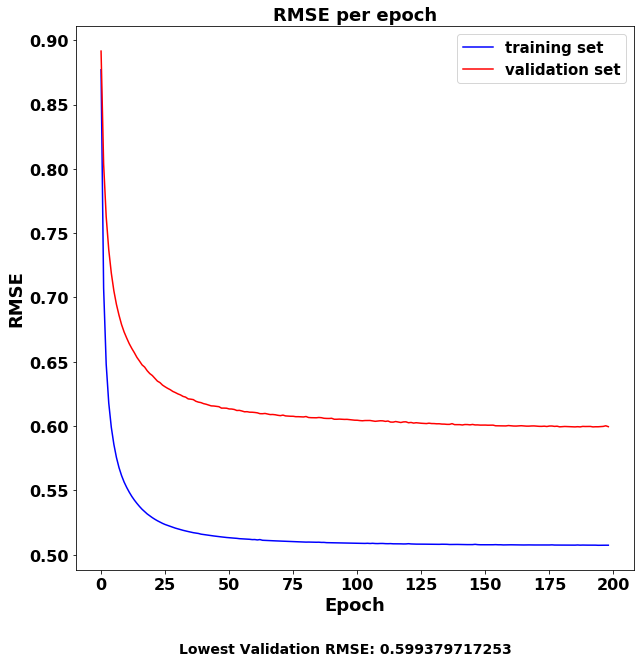

In [8]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory1.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory1.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(fitHistory1.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}_SAE_{}x{}x{}_norm_mapstd.{}'.format(saveFigDir, asset, inputDim1, nNeurons1, inputDim1, 'pdf'), bbox_inches='tight')

## Extracting autoencoder first layer to be used as encoder

In [9]:
encoder1layer = autoencoder1.get_layer(index=1)
encoder1 = Sequential([encoder1layer])
encoder1.compile(optimizer = 'adam', loss='mse')
encoder1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 30)                1230      
Total params: 1,230
Trainable params: 1,230
Non-trainable params: 0
_________________________________________________________________


## Encoding data for use as input in the next autoencoder 

In [10]:
xTrainEncoded1 = encoder1.predict(xTrain)

## Creating another autoencoder, for second layer 

In [11]:
inputDim2 = xTrainEncoded1.shape[1]
nNeurons2 = 20
nInits = 10

modelCheckpoint = ModelCheckpoint('{}/{}_SAE_{}x{}x{}_norm_mapstd.h5'.format(saveModelDir, asset, inputDim2, nNeurons2, inputDim2), 
                                      save_best_only=True)

bestValLoss = np.Inf
bestFitHistory = None
    
init_time = time.time()
for init in range(nInits):
    m_time = time.time()
    autoencoder2 = Sequential([
                               Dense(nNeurons2, activation = 'tanh', input_dim = inputDim2),
                               Dense(inputDim2, activation = 'tanh')
                              ])

    autoencoder2.compile(optimizer = 'adam', loss='mse', metrics=['accuracy', 'mae'])

    fitHistory = autoencoder2.fit(xTrainEncoded1, 
                                  xTrainEncoded1, 
                                  epochs = 2000,
                                  verbose = 0,
                                  shuffle = True,
                                  validation_split = 0.15, 
                                  callbacks = [earlyStopping,
                                               modelCheckpoint])
    if min(fitHistory.history['val_loss']) < bestValLoss:
        bestFitHistory = fitHistory
    print('Fitted ({}): {:.3f} seconds, RMSE {:.5f}'.format(init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

fitHistory2 = bestFitHistory
joblib.dump(fitHistory2.history, '{}/{}_SAE_{}x{}x{}_norm_mapstd_fitHistory.pkl'.format(saveVarDir, asset, inputDim2, nNeurons2, inputDim2))
autoencoder2 = load_model('{}/{}_SAE_{}x{}x{}_norm_mapstd.h5'.format(saveModelDir, asset, inputDim2, nNeurons2, inputDim2))
end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Time to fit model: 91.0104670525 seconds


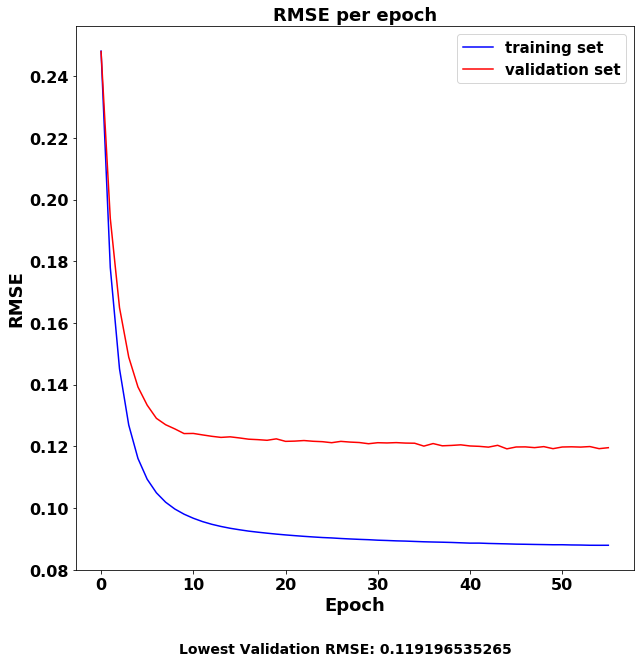

In [12]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory2.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory2.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(fitHistory2.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}_SAE_{}x{}x{}_norm_mapstd.{}'.format(saveFigDir, asset, inputDim2, nNeurons2, inputDim2, 'pdf'), bbox_inches='tight')

## Extracting autoencoder2 first layer to be used as encoder2

In [13]:
encoder2layer = autoencoder2.get_layer(index=1)
encoder2 = Sequential([encoder2layer])
encoder2.compile(optimizer = 'adam', loss='mse')
encoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 20)                620       
Total params: 620
Trainable params: 620
Non-trainable params: 0
_________________________________________________________________


## Encoding data for use as input in the next autoencoder 

In [14]:
xTrainEncoded2 = encoder2.predict(xTrainEncoded1)

## Creating another autoencoder, for third layer 

In [15]:
inputDim3 = xTrainEncoded2.shape[1]
nNeurons3 = 10
nInits = 10

modelCheckpoint = ModelCheckpoint('{}/{}_SAE_{}x{}x{}_norm_mapstd.h5'.format(saveModelDir, asset, inputDim3, nNeurons3, inputDim3), 
                                      save_best_only=True)

bestValLoss = np.Inf
bestFitHistory = None

init_time = time.time()
for init in range(nInits):
    m_time = time.time()
    autoencoder3 = Sequential([
                               Dense(nNeurons3, activation = 'tanh', input_dim = inputDim3),
                               Dense(inputDim3, activation = 'tanh')
                              ])

    autoencoder3.compile(optimizer = 'adam', loss='mse', metrics=['mae'])

    fitHistory = autoencoder3.fit(xTrainEncoded2, 
                                  xTrainEncoded2, 
                                  epochs = 2000,
                                  verbose = 0,
                                  shuffle = True,
                                  validation_split = 0.15, 
                                  callbacks = [earlyStopping,
                                               modelCheckpoint])
    if min(fitHistory.history['val_loss']) < bestValLoss:
        bestFitHistory = fitHistory
    print('Fitted ({}): {:.3f} seconds, RMSE {:.5f}'.format(init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

fitHistory3 = bestFitHistory
joblib.dump(fitHistory3.history, '{}/{}_SAE_{}x{}x{}_norm_mapstd_fitHistory.pkl'.format(saveVarDir, asset, inputDim3, nNeurons3, inputDim3))
autoencoder3 = load_model('{}/{}_SAE_{}x{}x{}_norm_mapstd.h5'.format(saveModelDir, asset, inputDim3, nNeurons3, inputDim3))
end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Time to fit model: 100.083296061 seconds


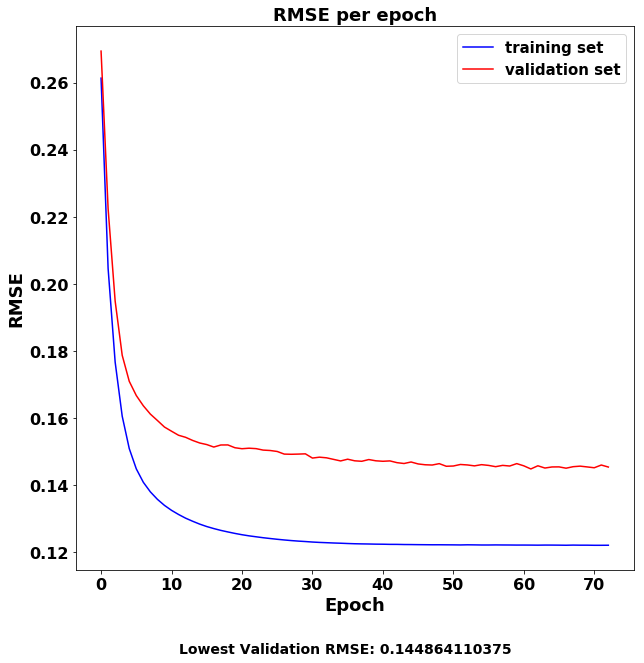

In [16]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory3.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory3.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(fitHistory3.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}_SAE_{}x{}x{}_norm_mapstd.{}'.format(saveFigDir, asset, inputDim3, nNeurons3, inputDim3, 'pdf'), bbox_inches='tight')

## Extracting autoencoder3 first layer to be used as encoder3

In [17]:
encoder3layer = autoencoder3.get_layer(index=1)
encoder3 = Sequential([encoder3layer])
encoder3.compile(optimizer = 'adam', loss='mse')
encoder3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 10)                210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


## Building SAE

In [18]:
modelCheckpoint = ModelCheckpoint('{}/{}_SAE_{}x{}x{}x{}x1_norm_mapstd.h5'.format(saveModelDir, asset, inputDim1, nNeurons1, nNeurons2, nNeurons3), 
                                      save_best_only=True)
SGD = optimizers.SGD(lr=0.01, momentum=0.10, decay=0.0, nesterov=False)
bestValLoss = np.Inf
bestFitHistory = None

_encoder1layer = autoencoder1.get_layer(index=1)
_encoder2layer = autoencoder2.get_layer(index=1)
_encoder3layer = autoencoder3.get_layer(index=1)

_encoder1layer.trainable = False
_encoder2layer.trainable = False
_encoder3layer.trainable = False

init_time = time.time()
for init in range(nInits):
    m_time = time.time()
    SAE = Sequential([
                      _encoder1layer, 
                      _encoder2layer, 
                      _encoder3layer,
                      Dense(1, activation='linear')
                     ])

    SAE.compile(optimizer = 'adam', loss='mse', metrics=['mae'])

    fitHistory = SAE.fit(xTrain, 
                         yTrain, 
                         epochs = 2000,
                         verbose = 0,
                         shuffle = True,
                         validation_split = 0.15, 
                         callbacks = [earlyStopping,
                                      modelCheckpoint])
    if min(fitHistory.history['val_loss']) < bestValLoss:
        bestFitHistory = fitHistory
    print('Fitted ({}): {:.3f} seconds, RMSE {:.5f}'.format(init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

fitHistory = bestFitHistory
joblib.dump(fitHistory.history, '{}/{}_SAE_{}x{}x{}x{}x1_norm_mapstd.pkl'.format(saveVarDir, asset, inputDim1, nNeurons1, nNeurons2, nNeurons3))
SAE = load_model('{}/{}_SAE_{}x{}x{}x{}x1_norm_mapstd.h5'.format(saveModelDir, asset, inputDim1, nNeurons1, nNeurons2, nNeurons3))

end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')
SAE.summary()

Time to fit model: 39.0181260109 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_31 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_49 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 11        
Total params: 2,071
Trainable params: 11
Non-trainable params: 2,060
_________________________________________________________________


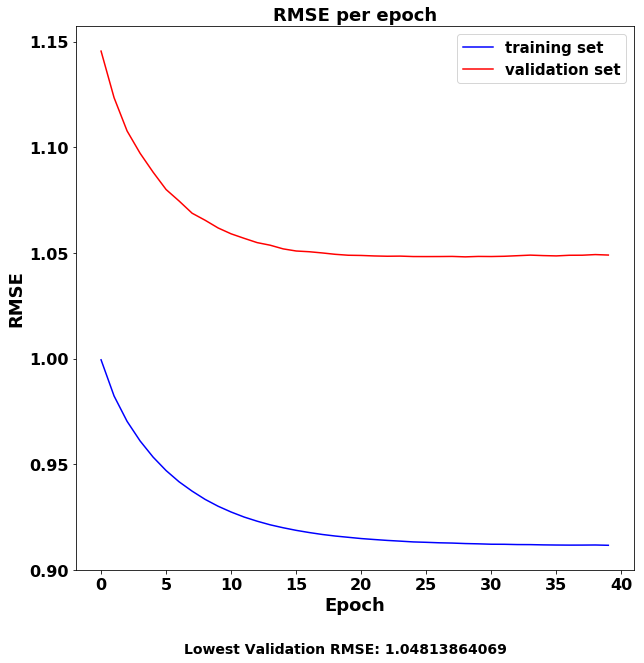

In [19]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(fitHistory.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}_SAE_{}x{}x{}x{}x1_norm_mapstd.{}'.format(saveFigDir, asset, inputDim1, nNeurons1, nNeurons2, nNeurons3, 'pdf'), bbox_inches='tight')

## Visualizing Predictions

(<matplotlib.figure.Figure at 0x7f94d08a81d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f94d08d1a50>)

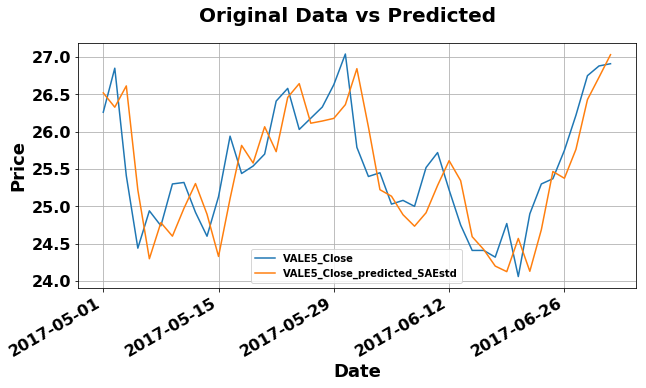

In [20]:
predictions = yScaler.inverse_transform(SAE.predict(xTest)).reshape(-1)
predictedResid = pd.Series(predictions, index = df['2017'].index, name = '{}_resid_predicted_SAEstd'.format(asset))
predictedClose = pd.Series(df['{}_Close_trend'.format(asset)] + predictedResid, name = '{}_Close_predicted_SAEstd'.format(asset))

plotSeries([df['{}_Close'.format(asset)], 
#            df['PETR4_Close_trend'],
            predictedClose],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

(<matplotlib.figure.Figure at 0x7f94d08a8450>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f94caccc1d0>)

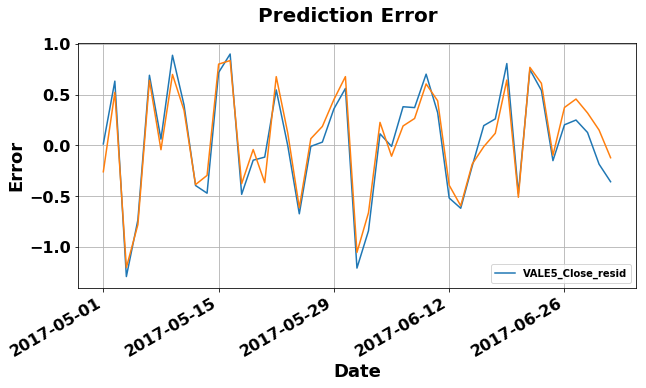

In [21]:
plotSeries([df['{}_Close_resid'.format(asset)], (df['{}_Close'.format(asset)] - predictedClose)],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'Error')

In [22]:
#SAE = load_model('{}/{}_SAE_40x30x20x10x1_norm_mapstd.h5'.format(saveModelDir, asset))
#predictions = yScaler.inverse_transform(SAE.predict(xTest)).reshape(-1)
#predictedResid = pd.Series(predictions, index = df['2017'].index, name = '{}_resid_predicted_SAEstd'.format(asset))
#predictedClose = pd.Series(df['{}_Close_trend'.format(asset)] + predictedResid, name = '{}_Close_predicted_SAEstd'.format(asset))

df = pd.concat([df, predictedResid, predictedClose], axis = 1)
df.to_csv('{}/{}_SAE_predicted.CSV'.format(saveVarDir, asset))

## Fine Tuning ?

In [23]:
modelCheckpoint = ModelCheckpoint('{}/{}_SAE_{}x{}x{}x{}x5x1_norm_mapstd.h5'.format(saveModelDir, asset, inputDim1, nNeurons1, nNeurons2, nNeurons3), 
                                      save_best_only=True)
bestValLoss = np.Inf
bestFitHistory = None

_encoder1layer = autoencoder1.get_layer(index=1)
_encoder2layer = autoencoder2.get_layer(index=1)
_encoder3layer = autoencoder3.get_layer(index=1)

_encoder1layer.trainable = False
_encoder2layer.trainable = False
_encoder3layer.trainable = False

init_time = time.time()
for init in range(nInits):
    m_time = time.time()
    SAE2 = Sequential([
                      _encoder1layer, 
                      _encoder2layer, 
                      _encoder3layer,
                      Dense(5, activation='tanh'),
                      Dense(1, activation='linear')
                     ])

    SAE2.compile(optimizer = 'adam', loss='mse', metrics=['mae'])

    fitHistory = SAE2.fit(xTrain, 
                          yTrain, 
                          epochs = 2000,
                          verbose = 0,
                          shuffle = True,
                          validation_split = 0.15, 
                          callbacks = [earlyStopping,
                                       modelCheckpoint])
    
    if min(fitHistory.history['val_loss']) < bestValLoss:
        bestFitHistory = fitHistory
    print('Fitted ({}): {:.3f} seconds, RMSE {:.5f}'.format(init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

fitHistory5 = bestFitHistory
joblib.dump(fitHistory.history, '{}/{}_SAE_{}x{}x{}x{}x5x1_norm_mapstd.pkl'.format(saveVarDir, asset, inputDim1, nNeurons1, nNeurons2, nNeurons3))
SAE2 = load_model('{}/{}_SAE_{}x{}x{}x{}x5x1_norm_mapstd.h5'.format(saveModelDir, asset, inputDim1, nNeurons1, nNeurons2, nNeurons3))

end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')
SAE2.summary()

Time to fit model: 33.4118928909 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_31 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_49 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 6         
Total params: 2,121
Trainable params: 61
Non-trainable params: 2,060
_________________________________________________________________


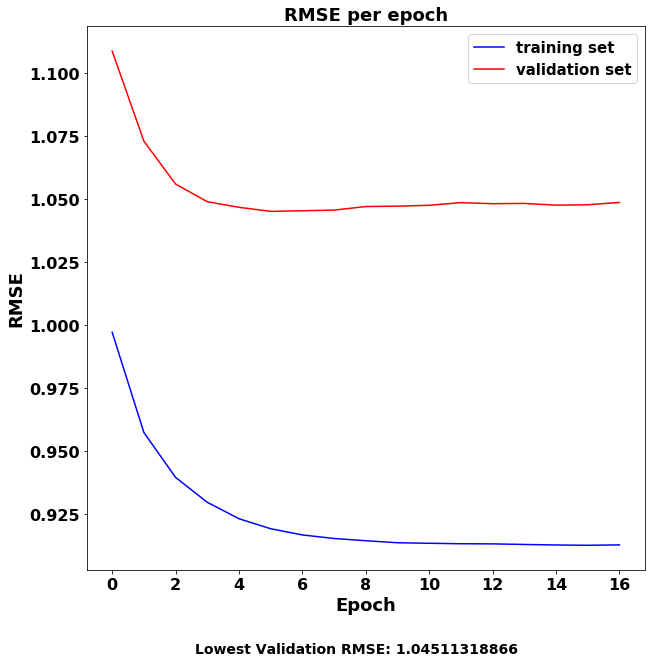

In [24]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory5.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory5.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(fitHistory5.history['val_loss']))), size = 14, horizontalalignment = 'center')